# Semantic Segmentation Job output conversion to COCO format
This notebook walks through converting the output from SageMaker Ground Truth Semantic segmentation task into Common Objects in Context (COCO) format. The output manifest of the semantic segmentation task contains a reference to a PNG file masks for the objects that has been annotated and saved in an Amazon S3 bucket. In this notebook, I will download a sample manifest file, convert the mask into a pixelated format as in the COCO format.

## Install Pre-requisites

In [ ]:
!pip install opencv-python pycocotools

## Get the output.manifest file

In [1]:
import boto3
import os

JOBNAME = '<LABELING JOB NAME>' #Replace it with the labeling job name
REGION = '<REGION>' #Replace it with the job region
client = boto3.client('sagemaker',region_name=REGION)
response = client.describe_labeling_job(LabelingJobName= JOBNAME)
file = response['LabelingJobOutput']['OutputDatasetS3Uri']
output_manifest = os.path.basename(file)
!aws s3 cp $file ./

download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-detection-2-clone/manifests/output/output.manifest to ./output.manifest


## Read the manifest file line by line and create "Images" key

In [2]:
import json
data_objs  = []
input_files = []
images = []
file_name = os.path.join("./", output_manifest)

#Assuming all images are reshaped to have the same dimensions
height = 3956
width = 5280

#Get data objects from the output manifest
with open(file_name) as out_manifest:
    for line in out_manifest:
        data_objs.append(json.loads(line))

#Get the input images filenames
for line in data_objs:
        input_files.append(os.path.join(*line['source-ref'].split('/')[3:]))

data_bucket = line['source-ref'].split('/')[2]
dir_path = os.path.dirname(data_objs[0]['source-ref'])
images_key = { 
              "coco_url": "",
              "date_captured": "",
              "flickr_url": "",
              "license": 0,
              "id": 0,
              "file_name": "",
              "height": height,
              "width": width
             }    
    
for img_id, input_file in enumerate(input_files):
    images_key["file_name"] = input_file #saving full path except bucket name. For sagemaker training, add /opt/ml/input/data prefix to the filename
    images_key["id"] = img_id
    images.append(images_key.copy())

## Identify and Get Categories

In [3]:
categories = []
classes = []
classnamesids= []
ids = []
names = []
mapping = {}
cat_hex_map = []

category = {
      "id": '',
      "name": '',
      "supercategory": ""
            }

for key in data_objs[0][JOBNAME + '-ref-metadata']['internal-color-map']:
    classname = data_objs[0][JOBNAME + '-ref-metadata']['internal-color-map'][key]['class-name']
    hexcolor = data_objs[0][JOBNAME + '-ref-metadata']['internal-color-map'][key]['hex-color']
    if classname == 'BACKGROUND':
        continue
    else:
        classnamesids.append((key, classname))
        mapping.update({hexcolor: key})

for idd, classname in classnamesids:   
    category['id'] = idd
    category['name'] = classname
    classes.append(classname)
    categories.append(category.copy())   

## Other static variables:

In [4]:
from datetime import datetime
date_now = datetime.today().strftime('%Y-%m-%d')
year = datetime.today().strftime('%Y')

licenses =  [
    {
      "name": "",
      "id": 0,
      "url": ""
    }
  ]
info =  {
    "contributor": "",
    "date_created": date_now,
    "description": "ENTER YOUR DESCRIPTION HERE",
    "url": "",
    "version": 3,
    "year": "2020"
  }

## Function to generate segmentation

In [5]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure
import cv2
from skimage import io

def generate_segmentation(img, category_id, idd, image_id):
    seg_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    seg_img = np.uint8(seg_img)
    f_bmask = np.asfortranarray(seg_img)
    encoded_GT = mask.encode(f_bmask)
    area_GT = mask.area(encoded_GT)
    bb_GT = mask.toBbox(encoded_GT)
    contours = measure.find_contours(seg_img, 0.5)
    annotation = {
            "category_id": category_id,
            "id": idd,
            "image_id": image_id,
            "iscrowd": 0,
            "segmentation": [],
            "area": area_GT.tolist(),
            "bbox": bb_GT.tolist(),
        }
    for contour in contours:
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        annotation["segmentation"].append(segmentation)
    return annotation

## Download the mask output from S3

### WARNING: This cell will download the annotated masks from S3 bucket.

If you have a very large dataset, you can either generate the segmentation data from masks using batches or make sure you have large enough storage to cater for the downloaded data

In [6]:
%matplotlib inline
import time

path = "/".join(data_objs[0][JOBNAME+'-ref'].split("/")[:-1]) + "/"
!aws s3 cp --recursive $path ./output_mask/

download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-detection-2-clone/annotations/consolidated-annotation/output/0_2020-01-24T21:19:23.744722.png to output_mask/0_2020-01-24T21:19:23.744722.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-detection-2-clone/annotations/consolidated-annotation/output/3_2020-01-24T21:13:12.974834.png to output_mask/3_2020-01-24T21:13:12.974834.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-detection-2-clone/annotations/consolidated-annotation/output/4_2020-01-24T21:17:30.086198.png to output_mask/4_2020-01-24T21:17:30.086198.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-detection-2-clone/annotations/consolidated-annotation/output/1_2020-01-24T21:17:29.521266.png to output_mask/1_2020-01-24T21:17:29.521266.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-detection-2-clone/annotations/consolidated-annotation/output/2

## Generate segmentation data

In [7]:
import os
import matplotlib
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

idd = 0
annotations = []
for image_id, file in enumerate(data_objs):
    segments = []
    img_file = os.path.join('output_mask/', os.path.basename(file[JOBNAME + '-ref']))
    a = io.imread(img_file,plugin='matplotlib')
    colors = np.unique(a.reshape(-1, a.shape[2]), axis=0)
    for i in range(colors.shape[0]):
        if colors[i][:-1].mean() < 1:
            segments.append(colors[i])
    
    for idds, seg in enumerate(range(len(segments))):
        print("Processing image {}:".format(img_file))
        color_hex = matplotlib.colors.to_hex(segments[seg])
        category_id = mapping[color_hex]
        img = io.imread(img_file, plugin='matplotlib')
        msk = segments[seg]  
        masked_img = cv2.inRange(img, msk, msk)
        if len(segments) > 1:
            img[masked_img>0]=(255,255,255,255)
        annot = generate_segmentation(img,category_id, idd, image_id)
        idd+=1
        annotations.append(annot)


Processing image output_mask/0_2020-01-24T21:19:23.744722.png:
Processing image output_mask/1_2020-01-24T21:17:29.521266.png:
Processing image output_mask/2_2020-01-24T21:15:24.152497.png:
Processing image output_mask/3_2020-01-24T21:13:12.974834.png:
Processing image output_mask/4_2020-01-24T21:17:30.086198.png:


## Construct the input COCO file

In [8]:
COCO_json = {
    "licenses": licenses,
    "info": info,
    "categories": categories,
    "images": images,
    "annotations": annotations
}
with open('COCO_file.json', 'w') as json_file:
        json.dump(COCO_json, json_file)

## Test and Visualize Each Unique Category Segmentation


This section is based on this notebook https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
bike motorbike

COCO supercategories: 

download: s3://sagemaker-us-east-1-625616379791/segment_label/160520-M-EZ287-251.JPG to test_images/segment_label/160520-M-EZ287-251.JPG


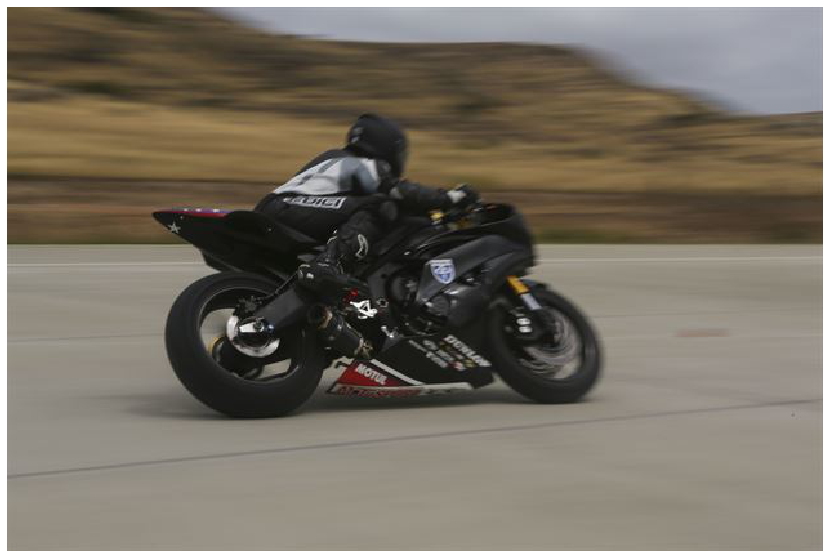

In [9]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import boto3
s3 = boto3.client('s3')


pylab.rcParams['figure.figsize'] = (20.0, 10.0)
annFile='COCO_file.json'
coco=COCO(annFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))
catIds = coco.getCatIds(catNms=classes)
imgIds = coco.getImgIds() 
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

#Create local path
folder = os.path.join(os.getcwd(), 'test_images', *img['file_name'].split('/')[:-1])
if not os.path.exists(folder):
    os.makedirs(folder)
    
#Download the image in the local directory
test_image = os.path.join('s3://', data_bucket, img['file_name'])
!aws s3 cp $test_image $folder

#Display the image
I = io.imread(os.path.join('./test_images', img['file_name']))
h, w, c = I.shape
plt.axis('off')
plt.imshow(I)
plt.show()

## Print out the annotations from the converted COCO format

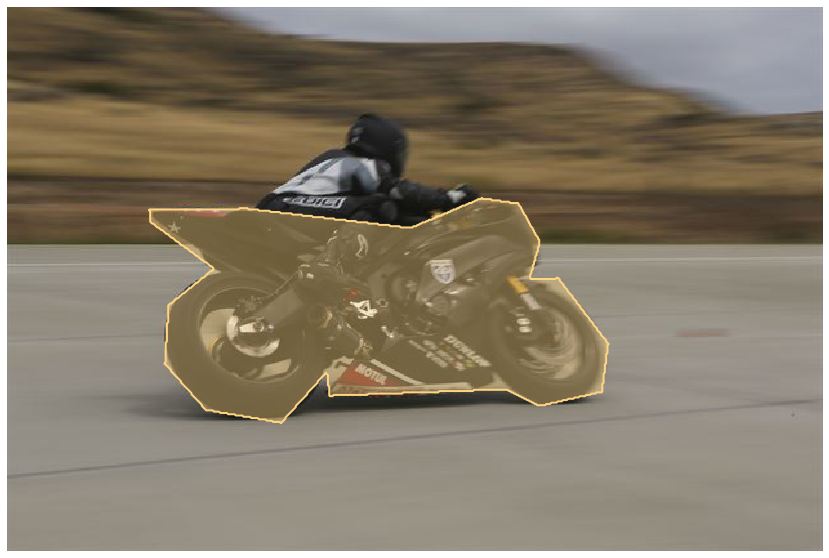

In [10]:
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)